In [80]:
# standard python utilities
import os
import sys
import glob
import pandas as pd
import numpy as np
import calendar
import time

# standard python plotting utilities
import matplotlib as mpl
import matplotlib.pyplot as plt

# standard geospatial python utilities
import pyproj # for converting proj4string
import shapely
import geopandas as gpd
import rasterio

# mapping utilities
import contextily as ctx
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.font_manager as fm

In [81]:

# run installed version of flopy or add local path
try:
    import flopy
    from flopy.discretization.structuredgrid import StructuredGrid
    from flopy.utils.reference import SpatialReference
    from flopy.utils import Raster
except:
    import flopy
    fpth = os.path.abspath(os.path.join('..', '..'))
    sys.path.append(fpth)
    from flopy.discretization.structuredgrid import StructuredGrid
    from flopy.utils.reference import SpatialReference
    from flopy.utils import Raster
from flopy.utils.gridgen import Gridgen
from flopy.utils import OptionBlock
import flopy.utils.binaryfile as bf


print(sys.version)
print('numpy version: {}'.format(np.__version__))
print('matplotlib version: {}'.format(mpl.__version__))
print('flopy version: {}'.format(flopy.__version__))

3.7.7 (default, May  6 2020, 11:45:54) [MSC v.1916 64 bit (AMD64)]
numpy version: 1.19.2
matplotlib version: 3.3.1
flopy version: 3.3.0


In [82]:
## Set up directory referencing
# Package data
gwfm_dir = os.path.dirname(os.path.dirname(os.getcwd()))

### Crop coefficients and ETo

In [83]:
# crop_path = uzf_path+'\\Oversized_rectangle_2007_2019'
uzf_path = gwfm_dir+'\\UZF_data'

crop_path = uzf_path+'\\Newmodeldomain_cropdata_2007_2019'

import pathlib

crop_raster_list = list(pathlib.Path(crop_path).glob('*.tif'))
crop_dbf_list = list(pathlib.Path(crop_path).glob('*.dbf'))


In [84]:
# A-B, A-C, A-D are the percent of the season for each Kc
# The dates are the dates of the growing season
Kc = pd.read_csv(uzf_path+'\\Kc\\Kc_Current.csv',skiprows = 1)
Kc = Kc.rename(columns={'Unnamed: 0' : 'Match_kc'})

In [85]:
def crop_raster2array(raster_file_name, dbf_filename, Kc):
    # read in crop raster and database of crop values
    src = rasterio.open(raster_file_name)
    crop_dbf = pd.DataFrame(gpd.read_file(dbf_filename))
        
    band1 = src.read(1)
    band1 = band1.astype('int16')
    band1 = band1.astype(float)
    band3 = band1.reshape(1, band1.shape[0], band1.shape[1])[:,:,:]
    # turn the rasterio format into a flopy format
    # for some reason flopy will not directly read in the raster .tif
    croprio = Raster(band3, bands = (1,), crs = src.crs, transform = src.transform, 
                 nodataval = 255)
    # no longer need to crop as data from USDA was downloaded to fit domain
    # crop the raster to the model domain
#     croprio.crop(vertices, invert=False)
    
    # The original crop raster has a cell size of 56 by 56 m so if there are less than 4 cells of one crop
    # then for certain they will not fill one cell and most likely have minimal impact considering there are 
    # 6300 model cells in one layer
    crop_hist = np.histogram(band3, bins = np.arange(0,257))
    # only need to filter out those that have no cells in the domain
    crops_in_domain = crop_hist[1][:-1][crop_hist[0]>1]
#     crops_in_domain = crop_hist[1][:-1]
    
    domain_dbf = crop_dbf.iloc[crops_in_domain]

    domain_dbf['CLASS_NAME'] = domain_dbf.CLASS_NAME.str.replace('Dbl Crop ','')
    domain_dbf['crop_hist'] = crop_hist[0][crops_in_domain]
    # remove the 0/background value from the domain_dbf because it messes with the crop histogram
    domain_dbf = domain_dbf.drop(0)
    # then create a column with the percent of the crop
    domain_dbf['crop_percent'] = 100*domain_dbf.crop_hist/domain_dbf.crop_hist.sum()
    Kcmatch = pd.read_csv(uzf_path+'\\Kc\\Cosumnes_crops.csv', index_col = 0)

    # domain_dbf['crop1'] = domain_dbf.CLASS_NAME.str.split('/', expand = True)[0]
    # domain_dbf['crop2'] = domain_dbf.CLASS_NAME.str.split('/', expand = True)[1]

    domain_dbf = domain_dbf.merge(Kcmatch, on = 'CLASS_NAME')
    domain_dbf = domain_dbf.merge(Kc, left_on = 'Match_kc', right_on = 'Match_kc', how = 'left')
    return(croprio, domain_dbf)


In [86]:
# Original model domain, 44.7 deg angle
# m_domain = gpd.read_file(gwfm_dir+'\\GWModelDomain_UTM10N\\GWModelDomain_Rec_UTM10N.shp')
# New model domain 52.9 deg
m_domain = gpd.read_file(gwfm_dir+'\\NewModelDomain\\GWModelDomain_52_9deg_UTM10N_WGS84.shp')

grid_p = gpd.read_file(gwfm_dir+'/DIS_data/grid/grid.shp')

In [87]:
loadpth = gwfm_dir+'/JupyterNotebooks/WEL/data'
m = flopy.modflow.Modflow.load('MF.nam', model_ws=loadpth, 
                                exe_name='mf-NWT', version='mfNWT')

In [88]:
vertices = list(m_domain.geometry.values[0].exterior.coords)[0:4]

## Rainfall and ET data from CIMIS

In [89]:
## Before resampling to the grid, I need to convert from a crop label with integer format to
## a crop coefficient format that is a float that can be weighted by the number of cells

In [90]:
## Potential ETo spatial interpolation from CIMIS
# daily_data = pd.read_csv(uzf_path+'\\Cosumnes_daily_multistations.csv',index_col = ['Date'], parse_dates = True)
daily_data = pd.read_csv(uzf_path+'\\Cosumnes_dailyET_precip_2010_01_01_to_2019_12_31.csv',index_col = ['Date'], parse_dates = True)

coords = pd.read_csv(uzf_path+'\\CIMIS_station_lat_long.csv', index_col = 0)
coords = gpd.GeoDataFrame(coords,geometry = gpd.points_from_xy(coords['Long'] ,coords['Lat']))
# Convert WGS Lat and long to Easting and Northing in Zone 10N
coords.crs = 'epsg:4326'
coords = coords.to_crs('epsg:32610')

# clean up data so columns are by location, units of ETo are in mm
ET = daily_data.pivot_table(index = 'Date', columns = ['Stn Id', 'Stn Name', 'CIMIS Region'], values = 'ETo (mm)')

# clean up data so columns are by location, units of Precip are in mm
rain = daily_data.pivot_table(index = 'Date', columns = ['Stn Id', 'Stn Name', 'CIMIS Region'], values = 'Precip (mm)')
# there are quite a few days missing rainfall at one station, could generally assume those are zero rain days

### Create monthly values of ET and rain

In [91]:
monthly_ET = ET.resample('M').sum()
monthly_rain = rain.resample('M').sum()

# Need to fix missing rainfall/ET data
temporary fix for now is to set any missing data to zero

Text(0, 0.5, 'Number of days with CIMIS data')

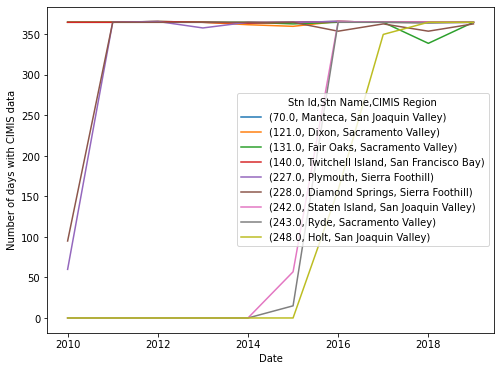

In [92]:
# rain.loc[rain.index > '2018-01-01'].iloc[34:40]
# Check on missing rain data, Ryde, Holt, and Staten Island aren't installed until 2015... need to find more stations
fig, ax = plt.subplots(figsize = (8,6))
rain.groupby(rain.index.year).count().plot(ax=ax)

plt.ylabel('Number of days with CIMIS data')
# plt.savefig('Plots/Model_SFR_UZF_progress/cimis_stations_data_availability.png', dpi = 600, bbox_inches='tight')

# Same situation for ET
# ET.groupby(rain.index.year).count().plot()

In [93]:
strt_date = rain.index.min()
end_date = rain.index.max()
print('Start Date:',strt_date,'End date:', end_date)
nrow = m.dis.nrow
ncol = m.dis.ncol

Start Date: 2010-01-01 00:00:00 End date: 2019-12-31 00:00:00


In [94]:
spd = rain.loc[strt_date:end_date]
in_xy = np.transpose(np.vstack([coords.geometry.x.values, coords.geometry.y.values]))

na_data = spd.iloc[i].notna().values
in_xy[na_data]

array([[ 656354.68847037, 4188975.78431486],
       [ 605904.06147471, 4252621.02436669],
       [ 654993.74245966, 4279438.78833564],
       [ 616189.14808344, 4220152.15169771]])

In [95]:
def gridded_interpolation_cimis(df):
    # dataframe is data from multiple cimis stations
    # that has been cleaned into multiple columns 
    # and sorted by date
    ncell = nrow*ncol

    # Filter climate data for the strt_date and end_date of the model stress periods
    spd = df.loc[strt_date:end_date]

    # Get the xy cell centers for the model grid
    xy = np.append(m.modelgrid.xcellcenters,m.modelgrid.ycellcenters, axis = 0)
    # reshape the xy data
    out_xy = np.transpose(np.vstack([np.reshape(xy[0:nrow], ncell),np.reshape(xy[nrow:],ncell)]))
    out_xy.shape, xy.shape
    # out_xy

    from scipy.interpolate import griddata
    in_xy = np.transpose(np.vstack([coords.geometry.x.values, coords.geometry.y.values]))
    # Final reshaped array of interpolated ET
    final = np.zeros((len(spd), nrow, ncol))

    for i in np.arange(0,len(spd)):
        # scipy interpolation based on point locations
        notna_data = spd.iloc[i].notna().values
        grid = griddata(in_xy[notna_data], spd.iloc[i].loc[notna_data].values, xi = out_xy, method = 'cubic')
        final[i,:,:] = np.reshape(grid, (nrow,ncol))
        
    return(final)


In [116]:
# interpolate between the CIMIS stations for gridded data via scipy.griddata
ET_final = gridded_interpolation_cimis(ET)
rain_final = gridded_interpolation_cimis(rain)
# calculate for monthly summed values
monthly_ET_final = gridded_interpolation_cimis(monthly_ET)
monthly_rain_final = gridded_interpolation_cimis(monthly_rain)

In [117]:
# convert from unis of mm to meters
ET_final = ET_final/1000
rain_final = rain_final/1000
monthly_ET_final = monthly_ET_final/1000
monthly_rain_final = monthly_rain_final/1000

rain_final.shape
# correct for any interpolated values that set rainfall or ETo to less than 0
ET_final[ET_final<0] = 0
rain_final[rain_final<0] = 0
monthly_ET_final[monthly_ET_final<0] = 0
monthly_rain_final[monthly_rain_final<0] = 0


## Simplified ETo with just Fair Oaks

In [98]:
ET_fo = ET.loc[:,(131.0, 'Fair Oaks', 'Sacramento Valley')]
# convert from mm to meters
ET_fo = ET_fo/1000
temp = np.ones((len(ET_fo), nrow,ncol))
for t in np.arange(0,len(ET_fo)):
    temp[t,:,:] = ET_fo.values[t]
    
ET_fo = temp


In [113]:
fig,ax=plt.subplots(figsize=(8,8))
plt.plot(ET_final[2800:,:,:].sum(axis=(1,2)),label = 'interp')
plt.plot(ET_fo[2800:,:,:].sum(axis=(1,2)),label = 'Fair Oaks')
plt.legend()

## Save rain and ET as arrays in text file format for easy model import

In [32]:
rain_index = 0
for y in np.arange(pd.to_datetime(strt_date).year, pd.to_datetime(end_date).year+1):
    # set start and end date for range for the year to be iterated over
    yr_strt = pd.to_datetime(str(y)+'-01-01')
    yr_end = pd.to_datetime(str(y)+'-12-31')
    if yr_strt < pd.to_datetime(strt_date):
        yr_strt = pd.to_datetime(strt_date)
    if yr_end > pd.to_datetime(end_date):
        yr_end = pd.to_datetime(end_date)
        
    yearlen = len(pd.date_range(yr_strt, yr_end))
    # calculate the ETc for the year and then save to a text file
    year_rain = rain_final[rain_index:rain_index+yearlen]
    reshaped_rain = np.reshape(year_rain, (year_rain.shape[0]*nrow, ncol))
    revert_rain = np.reshape(reshaped_rain, (year_rain.shape[0], nrow, ncol))
    print('Rehaping ETc and revert sum/check = ', (year_rain-revert_rain).sum())
    np.savetxt(gwfm_dir+'/UZF_data/Rain_all_txt_arrays/Rain_array_'+str(y)+'.tsv', reshaped_rain,  delimiter = '\t')
    rain_index += yearlen

Reshaping ETc and revert sum/check =  0.0
Reshaping ETc and revert sum/check =  0.0
Reshaping ETc and revert sum/check =  0.0
Reshaping ETc and revert sum/check =  0.0
Reshaping ETc and revert sum/check =  0.0
Reshaping ETc and revert sum/check =  0.0
Reshaping ETc and revert sum/check =  0.0
Reshaping ETc and revert sum/check =  0.0
Reshaping ETc and revert sum/check =  0.0
Reshaping ETc and revert sum/check =  0.0


The rain export to arrays works well, just need to check that the gridded_data matches the point data

889


<AxesSubplot:>

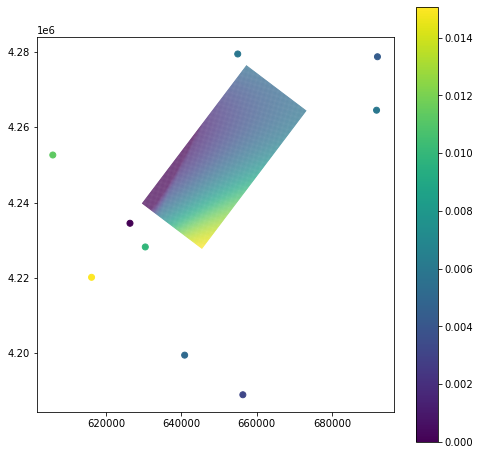

In [118]:
# find where substantial rain happens
where_rain = np.where(rain.mean(axis=1)>0.1)[0]
print(len(where_rain))
i = where_rain[800]

coords_plot = coords.copy()
coords_plot['rain_m'] = rain.iloc[i].values

fig, ax = plt.subplots(figsize=(8,8))
grid_p['rain_m'] = np.reshape(rain_final[i], nrow*ncol)
grid_p.plot('rain_m', ax=ax, legend = True)
coords_plot.plot('rain_m', ax=ax)

In [199]:
def calc_kc_dates(year, domain_dbf):
    # The year for each crop for each set of dates needs to change iteratively for each crop individually because
    # some crops have dates that extend into the next year that must not change until the final date of the 
    # season is reached (e.g. 2018-11-01 to 2019-09-17 must stay 2018 and 2019 until 2019-09-17 is reached)
#     i = 2018
    dates = domain_dbf.loc[:,['Beg Month','Beg Day', 'End Month', 'End Day', 'A-B', 'A-C', 'A-D']]

    # Set the pandas datetime from the start and end dates of crops
    # need to just takes .values or indexing will be wrong and mismatch dates to rows
    dates['A'] = pd.to_datetime({'year': year, 'month':dates['Beg Month'].values, 'day': dates['Beg Day'].values}).values
    dates['E'] = pd.to_datetime({'year': year, 'month':dates['End Month'].values, 'day': dates['End Day'].values}).values
    # Make correction for any end dates that are in the next year
    dates.E.loc[dates.E < dates.A] = dates.E.loc[dates.E < dates.A] + pd.offsets.DateOffset(years=1)

    # Get the length of the growing periods
    dates['num_days'] = dates.E-dates.A

    # set the end date of growing period A/ start of period B
    dates['B'] = dates.A + dates.num_days*(dates['A-B']/100)
    # Round the dates, as we will be one a daily time step
    dates.B = pd.to_datetime(dates.B.dt.date)

    # # set the end date of growing period B/ start of period C
    dates['C'] = dates.B + dates.num_days*((dates['A-C']-dates['A-B'])/100)

    # # set the end date of growing period C/ start of period D
    dates['D'] = dates.C + dates.num_days*((dates['A-D']-dates['A-C'])/100)
    return(dates)

In [134]:
def ETc_calc(ET_final, dates, domain_dbf):
    ETc = np.zeros((yearlen,nrow,ncol))
    Kc_arr = np.zeros((yearlen,nrow,ncol))

    time = 0
    for dt in pd.date_range(yr_strt, yr_end):
        # First step is to get the current Kc for each crop for the time step
        domain_dbf.Kc.loc[dt > dates.A] = domain_dbf.loc[dt > dates.A, 'Kc1']
        domain_dbf.Kc.loc[dt > dates.B] = domain_dbf.loc[dt > dates.B, 'Kc2']
        domain_dbf.Kc.loc[dt > dates.C] = domain_dbf.loc[dt > dates.C, 'Kc3']
        domain_dbf.Kc.loc[dt > dates.D] = domain_dbf.loc[dt > dates.D, 'Kc4']
        domain_dbf.Kc.loc[dt > dates.E] = domain_dbf.loc[dt > dates.E, 'Kc4']
        for i,j in zip(domain_dbf.index.values, domain_dbf.Kc.values):
            Kc_arr[time,crop_data==i] = j
        ETc[time,:,:] = Kc_arr[time,:,:]*ET_final[time,:,:]
        time += 1
    return(ETc, Kc_arr)

In [203]:
strt_date = rain.index.min()
end_date = rain.index.max()

In [77]:
strt_date, end_date

(Timestamp('2010-01-01 00:00:00'), Timestamp('2019-12-31 00:00:00'))

In [171]:
# end_date = pd.to_datetime('2010-12-31')

In [204]:

# for indexing the raster and database crop files
file_num = 0 
# for mapping ET_final from the whole period to just individual years
ET_index = 0

for y in np.arange(pd.to_datetime(strt_date).year, pd.to_datetime(end_date).year+1):
    # set start and end date for range for the year to be iterated over
    yr_strt = pd.to_datetime(str(y)+'-01-01')
    yr_end = pd.to_datetime(str(y)+'-12-31')
    if yr_strt < pd.to_datetime(strt_date):
        yr_strt = pd.to_datetime(strt_date)
    if yr_end > pd.to_datetime(end_date):
        yr_end = pd.to_datetime(end_date)
        
        
    # for each year, import the new crop raster and resample to the model grid
    # and filter out the database of crops to match those in the domain
    croprio, domain_dbf = crop_raster2array(crop_raster_list[file_num],crop_dbf_list[file_num], Kc)
    file_num +=1
    
    crop_data = croprio.resample_to_grid(m.modelgrid.xcellcenters,
                                m.modelgrid.ycellcenters,
                                band=croprio.bands[0],
                                method="nearest")
    # adjust domain_dbf to account for resampling
    resampled_crops = np.append(np.unique(crop_data).astype(int),np.unique(crop_data)[-1])
    resampled_hist =  np.histogram(crop_data, bins = resampled_crops)
    # convert histogram to dataframe to join with domain database info for crops
    resampled_hist = pd.DataFrame(np.transpose(np.vstack((resampled_hist[0], resampled_hist[1][:-1]))))
    resampled_hist.columns =  ['crop_hist','VALUE']
    resampled_hist.VALUE = resampled_hist.VALUE.astype(int)

    resampled_df = resampled_hist.set_index('VALUE').join(domain_dbf.drop('crop_hist', axis=1).set_index('VALUE') , on = 'VALUE', how = 'inner')
    resampled_df.crop_percent = 100*resampled_df.crop_hist/resampled_df.crop_hist.sum()
    resampled_df['Kc'] = 0
    
    # calculate the Kc date periods for each year
    dates = calc_kc_dates(y, domain_dbf = resampled_df)
    
    # find length of each year for referencing for the ET_final whole period to individual years
    yearlen = len(pd.date_range(yr_strt, yr_end))
    
    # calculate the ETc for the year and then save to a text file
#     ETc = ETc_calc(ET_final = ET_final[ET_index:ET_index+yearlen], dates=dates, domain_dbf= resampled_df)
#     ETc = ETc_calc(ET_final = monthly_ET_final[ET_index:ET_index+yearlen], dates=dates, domain_dbf= resampled_df)
    # alternative ET data set that uses only data from fair oaks
    ETc, Kc_arr = ETc_calc(ET_final = ET_fo[ET_index:ET_index+yearlen], dates=dates, domain_dbf= resampled_df)

    ET_index += yearlen
    reshapedETc = np.reshape(ETc, (yearlen*nrow, ncol))
    revertETc = np.reshape(reshapedETc, (yearlen, nrow, ncol))
    print('Reshaping ETc and revert sum/check = ', (ETc-revertETc).sum())
    np.savetxt(gwfm_dir+'/UZF_data/ETa_all_txt_arrays/ETa_array_'+str(y)+'.tsv', reshapedETc,  delimiter = '\t')

C:\Users\ajcalder\anaconda3\envs\geosp\lib\site-packages\ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\ajcalder\anaconda3\envs\geosp\lib\site-packages\ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\ajcalder\anaconda3\envs\geosp\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

Reshaping ETc and revert sum/check =  0.0
Reshaping ETc and revert sum/check =  0.0
Reshaping ETc and revert sum/check =  0.0
Reshaping ETc and revert sum/check =  0.0
Reshaping ETc and revert sum/check =  0.0
Reshaping ETc and revert sum/check =  0.0
Reshaping ETc and revert sum/check =  0.0
Reshaping ETc and revert sum/check =  0.0
Reshaping ETc and revert sum/check =  0.0
Reshaping ETc and revert sum/check =  0.0


3630


<AxesSubplot:>

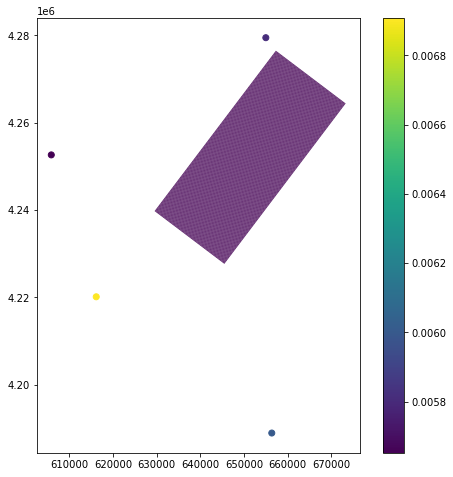

In [173]:
# find where substantial rain happens
where_ET = np.where(ET.mean(axis=1)>0.1)[0]
print(len(where_ET))
i = where_ET[200]

coords_plot = coords.copy()
coords_plot['ET_m'] = ET.iloc[i].values

fig, ax = plt.subplots(figsize=(8,8))
# grid_p['ET_m'] = np.reshape(ET_final[i], nrow*ncol)
grid_p['ET_m'] = np.reshape(ET_fo[i], nrow*ncol)
grid_p.plot('ET_m', ax=ax, legend = True)
coords_plot.plot('ET_m', ax=ax)

In [238]:
rain_final.shape, ET_final.shape, ETc.shape

((3652, 100, 230), (3652, 100, 230), (3652, 100, 230))

In [205]:
test2010 = np.loadtxt(gwfm_dir+'/UZF_data/ETa_all_txt_arrays/ETa_array_'+str(2010)+'.tsv', delimiter = '\t')
test2019 = np.loadtxt(gwfm_dir+'/UZF_data/ETa_all_txt_arrays/ETa_array_'+str(2019)+'.tsv', delimiter = '\t')

In [206]:
test2010.shape, test2019.shape

((36500, 230), (36500, 230))

In [207]:
yr_strt = pd.to_datetime(str(2010)+'-01-01')
yr_end = pd.to_datetime(str(2010)+'-12-31')
yearlen = len(pd.date_range(yr_strt, yr_end))
revert2010 = np.reshape(test2010, (yearlen, nrow, ncol))

yr_strt = pd.to_datetime(str(2019)+'-01-01')
yr_end = pd.to_datetime(str(2019)+'-12-31')
yearlen = len(pd.date_range(yr_strt, yr_end))
revert2019 = np.reshape(test2019, (yearlen, nrow, ncol))


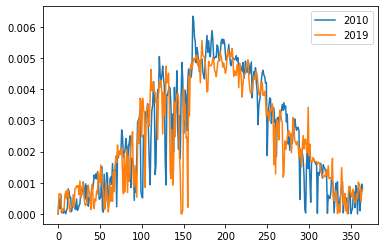

In [211]:
plt.plot(revert2010.mean(axis=(1,2)), label = '2010')
plt.plot(revert2019.mean(axis=(1,2)), label = '2019')
plt.legend()

## Data plotting for select years

In [14]:
len(crop_raster_list)
for i in np.arange(0,1):
    croprio, domain_dbf = crop_raster2array(crop_raster_list[i],crop_dbf_list[i], Kc)
    crop_data = croprio.resample_to_grid(m.modelgrid.xcellcenters,
                                m.modelgrid.ycellcenters,
                                band=croprio.bands[0],
                                method="nearest")
    temp = np.histogram(crop_data, bins = np.unique(crop_data))
    numcells = temp[0]
    cropval = temp[1]

C:\Users\ajcalder\anaconda3\envs\geosp\lib\site-packages\ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\ajcalder\anaconda3\envs\geosp\lib\site-packages\ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


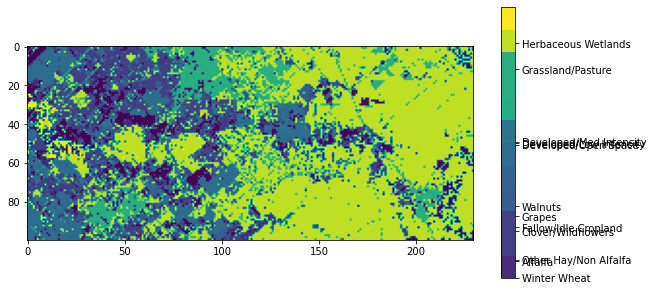

In [209]:
np.unique(crop_data)
fig,ax=plt.subplots(figsize=(10,10))
temp = np.zeros(crop_data.shape)
    
main_crops = domain_dbf.loc[domain_dbf.crop_percent>1]
main_crops

for n in main_crops.VALUE.values:
    temp[crop_data==n] = n
# plt.figure(figsize=(6,6))
ax.imshow(temp, cmap = 'viridis')
cbar = fig.colorbar(ax.images[0], ticks = main_crops.VALUE.values, values = main_crops.VALUE.values, shrink = 0.5)
cbar =cbar.ax.set_yticklabels(main_crops.CLASS_NAME.values)  

In [23]:
# find the unique crop values in the resampled array and add one value at the end for the
# histogram that groups from first value to less than the next value except for the last
# number which includes both (e.g. [1,2), [2,3) [3,3]])
resampled_crops = np.append(np.unique(crop_data).astype(int),np.unique(crop_data)[-1])
resampled_hist =  np.histogram(crop_data, bins = resampled_crops)
# convert histogram to dataframe to join with domain database info for crops
resampled_hist = pd.DataFrame(np.transpose(np.vstack((resampled_hist[0], resampled_hist[1][:-1]))))
resampled_hist.columns =  ['crop_hist','VALUE']
resampled_hist.VALUE = resampled_hist.VALUE.astype(int)

resampled_df = resampled_hist.set_index('VALUE').join(domain_dbf.drop('crop_hist', axis=1).set_index('VALUE') , on = 'VALUE', how = 'inner')
resampled_df.crop_percent = 100*resampled_df.crop_hist/resampled_df.crop_hist.sum()


The total cells originally:  293360 The total cells after resampling:  22999.0
% of 56mx56m domain covered by major crops (>1%):  93.56928562111398
% of 200mx200m domain covered by major crops (>1%):  93.56728933733297


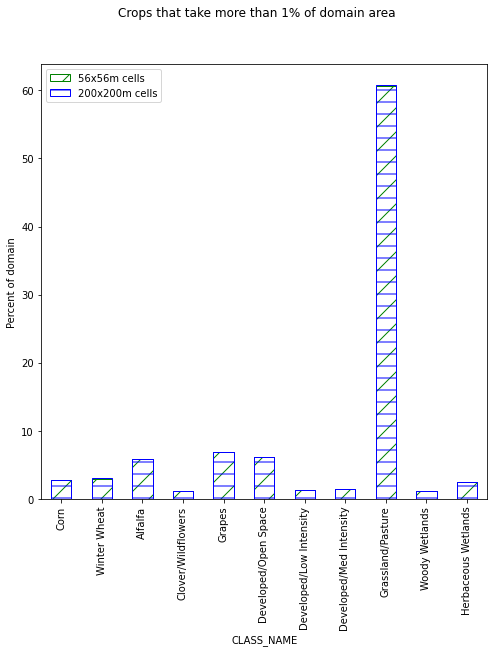

In [24]:
fig,ax = plt.subplots(figsize=(8,8))

print('The total cells originally: ', domain_dbf.crop_hist.sum(), 'The total cells after resampling: ', resampled_df.crop_hist.sum())

domain_dbf.loc[domain_dbf.crop_percent>1].plot(x='CLASS_NAME', y= 'crop_percent', 
                                               kind = 'bar', label = '56x56m cells', ax=ax, 
                                               edgecolor = 'green',fill = None, hatch = '/', alpha = 1)
plt.xlabel('Crop type')
plt.ylabel('Percent of domain')
plt.suptitle('Crops that take more than 1% of domain area')

resampled_df.loc[resampled_df.crop_percent>1].plot(x='CLASS_NAME', y= 'crop_percent',
                                                   kind = 'bar', label = '200x200m cells', ax=ax, 
                                                   edgecolor = 'blue', fill = None, hatch = '-',alpha =  1)
plt.savefig('Plots/crop_percents_before_after_nearest_resampling.png', dpi = 600, bbox_inches='tight')

print('% of 56mx56m domain covered by major crops (>1%): ', resampled_df.loc[resampled_df.crop_percent>1].crop_percent.sum())
print('% of 200mx200m domain covered by major crops (>1%): ', domain_dbf.loc[domain_dbf.crop_percent>1].crop_percent.sum())


In [ ]:
# set start and end date for range for the year to be iterated over
yr_strt = pd.to_datetime(str(y)+'-01-01')
yr_end = pd.to_datetime(str(y)+'-12-31')
if yr_strt < pd.to_datetime(strt_date):
    yr_strt = pd.to_datetime(strt_date)
if yr_end > pd.to_datetime(end_date):
    yr_end = pd.to_datetime(end_date)


# for each year, import the new crop raster and resample to the model grid
# and filter out the database of crops to match those in the domain
croprio, domain_dbf = crop_raster2array(crop_raster_list[file_num],crop_dbf_list[file_num], Kc)
file_num +=1

crop_data = croprio.resample_to_grid(m.modelgrid.xcellcenters,
                            m.modelgrid.ycellcenters,
                            band=croprio.bands[0],
                            method="nearest")
# adjust domain_dbf to account for resampling
resampled_crops = np.append(np.unique(crop_data).astype(int),np.unique(crop_data)[-1])
resampled_hist =  np.histogram(crop_data, bins = resampled_crops)
# convert histogram to dataframe to join with domain database info for crops
resampled_hist = pd.DataFrame(np.transpose(np.vstack((resampled_hist[0], resampled_hist[1][:-1]))))
resampled_hist.columns =  ['crop_hist','VALUE']
resampled_hist.VALUE = resampled_hist.VALUE.astype(int)

resampled_df = resampled_hist.set_index('VALUE').join(domain_dbf.drop('crop_hist', axis=1).set_index('VALUE') , on = 'VALUE', how = 'inner')
resampled_df.crop_percent = 100*resampled_df.crop_hist/resampled_df.crop_hist.sum()
resampled_df['Kc'] = 0

# calculate the Kc date periods for each year
dates = calc_kc_dates(y, domain_dbf = resampled_df)

# find length of each year for referencing for the ET_final whole period to individual years
yearlen = len(pd.date_range(yr_strt, yr_end))
ETc = np.zeros((yearlen,nrow,ncol))

# calculate the ETc for the year and then save to a text file
#     ETc = ETc_calc(ET_final = ET_final[ET_index:ET_index+yearlen], dates=dates, domain_dbf= resampled_df)
#     ETc = ETc_calc(ET_final = monthly_ET_final[ET_index:ET_index+yearlen], dates=dates, domain_dbf= resampled_df)
# alternative ET data set that uses only data from fair oaks
ETc = ETc_calc(ET_final = ET_fo[ET_index:ET_index+yearlen], dates=dates, domain_dbf= resampled_df)

In [ ]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(1, 1, 1, aspect='equal')

ax = croprio.plot(ax=ax)
ax.levels = domain_dbf.VALUE.values 

num_vals = len(domain_dbf.VALUE.values)
# bounds = domain_dbf.VALUE.values
# norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

cbar = plt.colorbar(ax.images[0], ticks = domain_dbf.VALUE.values, values = domain_dbf.VALUE.values)
cbar.ax.set_yticklabels(domain_dbf.CLASS_NAME.values)  

# newcbar = np.zeros((num_vals,3))
# for i in np.arange(num_vals):
#     newcbar[i,:] = cbar.cmap.colors[domain_dbf.VALUE.values[i]]
# cbar.cmap.N = num_vals
# cbar.cmap.colors = newcbar 

ax.ticklabel_format(style='plain')
plt.xlabel('Easting (m)')
plt.ylabel('Northing (m)')
# plt.savefig('Plots/Model_SFR_UZF_Progress/model_domain_crop_map.png', dpi = 300)

## Determining locations of ag land for logical array

In [200]:
crop_path = uzf_path+'\\Newmodeldomain_cropdata_2007_2019'
import pathlib
crop_raster_list = list(pathlib.Path(crop_path).glob('*.tif'))
crop_dbf_list = list(pathlib.Path(crop_path).glob('*.dbf'))


In [201]:
# read in crop raster and database of crop values
src = rasterio.open(crop_raster_list[-1])
crop_dbf = pd.DataFrame(gpd.read_file(crop_dbf_list[-1]))

band1 = src.read(1)
band1 = band1.astype('int16')
band1 = band1.astype(float)
band3 = band1.reshape(1, band1.shape[0], band1.shape[1])[:,:,:]
# turn the rasterio format into a flopy format
croprio = Raster(band3, bands = (1,), crs = src.crs, transform = src.transform, 
             nodataval = 255)

# The original crop raster has a cell size of 56 by 56 m so if there are less than 4 cells of one crop
# then for certain they will not fill one cell and most likely have minimal impact considering there are 
# 6300 model cells in one layer
crop_hist = np.histogram(band3, bins = np.arange(0,257))
# only need to filter out those that have no cells in the domain
crops_in_domain = crop_hist[1][:-1][crop_hist[0]>1]
#     crops_in_domain = crop_hist[1][:-1]

domain_dbf = crop_dbf.iloc[crops_in_domain]

domain_dbf['CLASS_NAME'] = domain_dbf.CLASS_NAME.str.replace('Dbl Crop ','')
domain_dbf['crop_hist'] = crop_hist[0][crops_in_domain]
# remove the 0/background value from the domain_dbf because it messes with the crop histogram
domain_dbf = domain_dbf.drop(0)
# then create a column with the percent of the crop
domain_dbf['crop_percent'] = 100*domain_dbf.crop_hist/domain_dbf.crop_hist.sum()


C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [237]:

# crop_data = croprio.resample_to_grid(m.modelgrid.xcellcenters,
#                                 m.modelgrid.ycellcenters,
#                                 band=croprio.bands[0],
#                                 method="nearest")

# # this is the same code accomplised by resample_to_grid taken directly from the flopy documentation because it was struggling
# # to reference scipy.interpolate.griddata
# crop_data = griddata( (croprio.xcenters.flatten(),croprio.ycenters.flatten()),
#          croprio.get_array(croprio.bands[0],masked=True).flatten(),
#          (m.modelgrid.xcellcenters.flatten(), m.modelgrid.ycellcenters.flatten()),
#          method="nearest")
# crop_data.shape = (100,230)

In [368]:
# ag_land_arr = np.ones(crop_data.shape)
# non_ag_land = ['Grassland/Pasture', 'Woody Wetlands','Herbaceous Wetlands', 'Open Water', 'Developed/Open Space',
#                'Developed/Low Intensity',  'Developed/Med Intensity', 'Developed/High Intensity', 'Barren',
#                'Fallow/Idle Cropland','Deciduous Forest', 'Evergreen Forest', 'Mixed Forest', 'Shrubland']
# # filter domain crop for developed land
# non_ag_land = domain_dbf.set_index('CLASS_NAME').filter(items =non_ag_land, axis=0)
# # find where in the crop array the pasture land is and set to 0
# for n in np.arange(0,len(non_ag_land)):
#     ag_land_arr[crop_data==non_ag_land.VALUE.values[n]] = 0